In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
import time

from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np
from graph_nets.demos import models
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
import os
from Simulation_functions_changed_energy import SpringMassSimulator, generate_trajectory, roll_out_physics
from Graph_creator_functions_changed_energy import base_graph

try:
    import seaborn as sns
except ImportError:
    pass
else:
    sns.reset_orig()

SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

/home/vabence/anaconda3/envs/TensorEnv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/vabence/anaconda3/envs/TensorEnv/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/vabence/anaconda3/envs/TensorEnv/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


## Declare loss opration

In [9]:

def create_loss_ops_with_energy(target_op, output_ops,target_edges,target_global_energy):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op."""

    
    loss_ops = [
                tf.reduce_mean(tf.reduce_sum(
                (tf.cast(
                    output_op.nodes,tf.float64) - tf.cast(tf.concat([target_op[..., 2:4],target_op[...,5:6]],axis=-1)
                                                          ,tf.float64))**2, axis=-1))
                +
                tf.reduce_mean(tf.reduce_sum(
                (tf.cast(
                    output_op.edges[...,2:3],tf.float64) - tf.cast(target_edges[...,2:3]
                                                          ,tf.float64))**2, axis=-1))
              
                
        
        
        
                #+ tf.reduce_sum(
                #(tf.cast(output_op.globals[...,2:3],tf.float64)-tf.cast(target_global_energy[..., 2:3],tf.float64))**2)/pern
             for output_op in output_ops
    ]
    return loss_ops


def create_loss_ops(target_op, output_ops):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op.""" 
    loss_ops = [
            tf.reduce_mean(
            tf.reduce_sum((tf.cast(output_op.nodes[...,2:3],tf.float64) - tf.cast(target_op[..., 2:4],tf.float64))**2, axis=-1))
            for output_op in output_ops
    ]
    return loss_ops





def make_all_runnable_in_session(*args):
    """Apply make_runnable_in_session to an iterable of graphs."""
    return [utils_tf.make_runnable_in_session(a) for a in args]


# pylint: enable=redefined-outer-name

# Training the Network: Chain with Energy
## Generate:
- Model
- Training trajectory
- Generalization trajectories: 4 mass, 9 mass

In [10]:

tf.reset_default_graph()

rand = np.random.RandomState(SEED)

# Model parameters.
num_processing_steps_tr = 1
num_processing_steps_ge = 1

# Data / training parameters.~
num_training_iterations = 150000
batch_size_tr = 256
batch_size_ge = 128
num_time_steps = 50
step_size = 0.1

num_masses_min_max_tr = (4, 10)


# Create the model.
model = models.EncodeProcessDecode(node_output_size=3,edge_output_size=3,global_output_size=3)

num_masses_tr = rand.randint(*num_masses_min_max_tr, size=batch_size_tr)
static_graph_tr = [base_graph(n,True, 50., 0.7, 0.) for n in num_masses_tr]
#base_graph_tr_np = utils_np.data_dicts_to_graphs_tuple([base_graph(4,True, 50., 0.7, 0.)]*)

base_graph_tr =  utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)
#base_graph_tr =  utils_tf.data_dicts_to_graphs_tuple([base_graph(4,True, 50., 0.7, 0.)] * batch_size_tr)

base_graph_4_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(4,True, 50., 0.7, 0.)] * batch_size_ge)
# 9 masses 0.5m apart in a chain like structure.
base_graph_9_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(9,True, 50., 0.7, 0.)] * batch_size_ge)

simulator = SpringMassSimulator(step_size=step_size)
# Training.
# Generate a training trajectory by adding noise to initial
# position, spring constants and gravity
initial_conditions_tr, true_trajectory_tr, true_edges_tr_per_step, true_globals_tr_per_step = generate_trajectory(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0,
    do_set_rest=True,do_apply_gravity=True)

t = tf.random_uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
input_graph_tr = input_graph_tr.replace(edges=true_edges_tr_per_step[t])
target_nodes_tr = true_trajectory_tr[t + 1]
target_edges_tr = true_edges_tr_per_step[t + 1]
target_globals_tr = true_globals_tr_per_step[t + 1]

output_ops_tr = model(input_graph_tr, num_processing_steps_tr)


# Test data: 4-mass string.
initial_conditions_4_ge, _, _, _ = generate_trajectory(
    lambda x: model(x, num_processing_steps_ge),
    base_graph_4_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0,
    do_set_rest=True,do_apply_gravity=True)

_, true_nodes_rollout_4_ge,true_edges_4_per_step, true_globals_4_per_step = roll_out_physics(
    simulator, initial_conditions_4_ge, num_time_steps, step_size)
_, predicted_nodes_rollout_4_ge,predicted_edges_4_per_step, predicted_globals_4_per_step = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_4_ge,num_time_steps, step_size)



# Test data: 9-mass string.
initial_conditions_9_ge, _, _, _ = generate_trajectory(
    lambda x: model(x, num_processing_steps_ge),
    base_graph_9_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0,
    do_set_rest=True,do_apply_gravity=True)

_, true_nodes_rollout_9_ge,true_edges_9_per_step,true_globals_9_per_step = roll_out_physics(
    simulator, initial_conditions_9_ge, num_time_steps, step_size)
_, predicted_nodes_rollout_9_ge,predicted_edges_9_per_step,predicted_globals_9_per_step = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_9_ge,num_time_steps, step_size)

# Training loss.
loss_ops_tr = create_loss_ops_with_energy(target_nodes_tr, output_ops_tr,target_edges_tr,target_globals_tr)
#loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.


loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss: 4-mass.
loss_op_4_ge = tf.reduce_mean(
                tf.reduce_sum(
                    (predicted_nodes_rollout_4_ge[..., 2:4]-true_nodes_rollout_4_ge[..., 2:4])**2,axis=-1))

loss_op_4_ge +=tf.reduce_mean(
                    (predicted_globals_4_per_step[...,2:3]-true_globals_4_per_step[...,2:3])**2)
      
# Test/generalization loss: 9-mass string.
loss_op_9_ge = tf.reduce_mean(
                tf.reduce_sum(
                    (predicted_nodes_rollout_9_ge[..., 2:4] - true_nodes_rollout_9_ge[..., 2:4])**2,axis=-1)) 

loss_op_9_ge += tf.reduce_mean(
                    (predicted_globals_9_per_step[...,2:3]-true_globals_9_per_step[...,2:3])**2) 
  



# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

input_graph_tr = make_all_runnable_in_session(input_graph_tr)
initial_conditions_4_ge = make_all_runnable_in_session(initial_conditions_4_ge)
initial_conditions_9_ge = make_all_runnable_in_session(initial_conditions_9_ge)


In [11]:
#@title Reset session  { form-width: "30%" }

# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
losses_4_ge = []
losses_9_ge = []

In [13]:
# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), "
      "Lge4 (test/generalization rollout loss for 4-mass strings), "
      "Lge9 (test/generalization rollout loss for 9-mass strings)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "input_graph": input_graph_tr,
        "target_nodes": target_nodes_tr,
        "target_edges":target_edges_tr,
        "target_globals":true_globals_tr_per_step,
        "outputs": output_ops_tr})
    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    if elapsed_since_last_log > log_every_seconds:
        last_log_time = the_time
        test_values = sess.run({
            "loss_4": loss_op_4_ge,
            "true_rollout_4": true_nodes_rollout_4_ge,
            "true_globals_4": true_globals_4_per_step,
            "true_edges_4": true_edges_4_per_step,
            "predicted_rollout_4": predicted_nodes_rollout_4_ge,
            "predicted_globals_4": predicted_globals_4_per_step,
            "predicted_edges_4": predicted_edges_4_per_step,
            "loss_9": loss_op_9_ge,
            "true_rollout_9": true_nodes_rollout_9_ge,
            "true_globals_9": true_globals_9_per_step,
            "true_edges_9": true_edges_9_per_step,
            "predicted_rollout_9": predicted_nodes_rollout_9_ge,
            "predicted_globals_9": predicted_globals_9_per_step,
            "predicted_edges_9":predicted_edges_9_per_step})
        elapsed = time.time() - start_time
        losses_tr.append(train_values["loss"])
        losses_4_ge.append(test_values["loss_4"])
        losses_9_ge.append(test_values["loss_9"])
        logged_iterations.append(iteration)
        print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge4 {:.4f}, Lge9 {:.4f}".format(
            iteration, elapsed, train_values["loss"], test_values["loss_4"],test_values["loss_9"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), Lge4 (test/generalization rollout loss for 4-mass strings), Lge9 (test/generalization rollout loss for 9-mass strings)
# 00033, T 22.3, Ltr 38.1117, Lge4 2107.5271, Lge9 86719.9833
# 00065, T 41.3, Ltr 34.4207, Lge4 2144.0193, Lge9 85827.6686
# 00100, T 61.7, Ltr 33.1601, Lge4 2121.1049, Lge9 86521.7910
# 00135, T 82.0, Ltr 25.8698, Lge4 2108.5333, Lge9 87013.6974
# 00170, T 102.4, Ltr 58.2109, Lge4 2145.3027, Lge9 86003.7203
# 00205, T 122.7, Ltr 22.2369, Lge4 2121.7721, Lge9 86669.0550
# 00240, T 143.0, Ltr 49.2184, Lge4 2111.9648, Lge9 86469.5011
# 00275, T 163.4, Ltr 33.2248, Lge4 2099.3676, Lge9 86488.6568
# 00310, T 183.7, Ltr 58.5402, Lge4 2133.1929, Lge9 86868.8213
# 00345, T 204.1, Ltr 15.2268, Lge4 2068.4945, Lge9 84697.4167
# 00377, T 224.2, Ltr 72.0400, Lge4 2118.2638, Lge9 84695.3444
# 00412, T 244.7, Ltr 0.5127, Lge4 2129.9398, Lge9 84197.9998
# 00447, T 265.1, Ltr 12.3774, Lge4 2146.4295, Lge9 86534.7

# 04506, T 2623.8, Ltr 1.4392, Lge4 2072.5650, Lge9 87314.8288
# 04541, T 2644.1, Ltr 0.8675, Lge4 2110.4675, Lge9 86459.9992
# 04576, T 2664.4, Ltr 4.8649, Lge4 2101.3415, Lge9 86617.3107
# 04611, T 2684.7, Ltr 0.4406, Lge4 2105.3624, Lge9 86075.3042
# 04646, T 2705.1, Ltr 5.5818, Lge4 2094.4707, Lge9 86707.7271
# 04681, T 2725.5, Ltr 4.0637, Lge4 2115.1544, Lge9 86116.7571
# 04716, T 2745.8, Ltr 6.0399, Lge4 2117.6214, Lge9 87149.4536
# 04751, T 2766.1, Ltr 2.6206, Lge4 2116.6299, Lge9 86193.2045
# 04786, T 2786.5, Ltr 2.6974, Lge4 2094.8592, Lge9 86491.2577
# 04821, T 2806.8, Ltr 3.0450, Lge4 2090.5149, Lge9 86845.7664
# 04856, T 2827.1, Ltr 3.4826, Lge4 2087.2181, Lge9 86526.9230
# 04891, T 2847.4, Ltr 5.9095, Lge4 2112.1098, Lge9 86044.9909
# 04926, T 2867.8, Ltr 5.3507, Lge4 2112.9198, Lge9 86209.9108
# 04961, T 2888.1, Ltr 3.4035, Lge4 2102.4385, Lge9 85037.3345
# 04996, T 2908.4, Ltr 5.1872, Lge4 2134.5223, Lge9 86392.2545
# 05031, T 2928.8, Ltr 2.5678, Lge4 2078.6543, Lge9 862

# 09091, T 5287.6, Ltr 4.8689, Lge4 2101.1459, Lge9 85604.7996
# 09126, T 5307.9, Ltr 2.6651, Lge4 2091.8133, Lge9 85271.4656
# 09161, T 5328.2, Ltr 4.4365, Lge4 2090.8573, Lge9 86718.1510
# 09196, T 5348.5, Ltr 6.3243, Lge4 2102.6792, Lge9 85589.9137
# 09231, T 5368.8, Ltr 5.3554, Lge4 2104.6820, Lge9 85958.0210
# 09266, T 5389.2, Ltr 2.4612, Lge4 2102.0636, Lge9 85927.7767
# 09301, T 5409.5, Ltr 1.6891, Lge4 2113.7278, Lge9 86797.6259
# 09336, T 5429.8, Ltr 4.1521, Lge4 2060.1184, Lge9 84971.6662
# 09371, T 5450.2, Ltr 3.4293, Lge4 2127.9684, Lge9 85300.9395
# 09406, T 5470.5, Ltr 3.8212, Lge4 2079.6586, Lge9 86531.4439
# 09441, T 5490.8, Ltr 1.6279, Lge4 2113.4433, Lge9 86933.5485
# 09476, T 5511.2, Ltr 3.7833, Lge4 2076.4830, Lge9 86025.5958
# 09511, T 5531.5, Ltr 1.6273, Lge4 2067.4845, Lge9 86841.9381
# 09546, T 5551.8, Ltr 3.3026, Lge4 2091.9496, Lge9 85272.9304
# 09581, T 5572.1, Ltr 2.4244, Lge4 2085.9331, Lge9 87562.0603
# 09616, T 5592.5, Ltr 0.1135, Lge4 2072.9072, Lge9 839

# 13676, T 7951.2, Ltr 1.0601, Lge4 2093.5032, Lge9 88191.5226
# 13711, T 7971.5, Ltr 0.4406, Lge4 2073.7247, Lge9 86784.3912
# 13746, T 7991.8, Ltr 1.8114, Lge4 2069.5178, Lge9 85662.0734
# 13781, T 8012.1, Ltr 2.3219, Lge4 2100.4563, Lge9 85579.5766
# 13816, T 8032.5, Ltr 3.3270, Lge4 2103.4257, Lge9 85963.8720
# 13851, T 8052.8, Ltr 3.3344, Lge4 2119.3718, Lge9 87125.8019
# 13886, T 8073.1, Ltr 1.7159, Lge4 2088.1521, Lge9 85807.4358
# 13921, T 8093.5, Ltr 3.5564, Lge4 2078.0890, Lge9 88879.6712
# 13956, T 8113.8, Ltr 3.4548, Lge4 2094.4215, Lge9 85827.0051
# 13991, T 8134.1, Ltr 1.4421, Lge4 2098.3805, Lge9 85860.7449
# 14026, T 8154.5, Ltr 1.6990, Lge4 2080.0273, Lge9 85572.9678
# 14061, T 8174.8, Ltr 3.3217, Lge4 2075.0121, Lge9 86982.4970
# 14096, T 8195.1, Ltr 3.0859, Lge4 2115.8123, Lge9 85446.6814
# 14131, T 8215.5, Ltr 3.0651, Lge4 2085.6700, Lge9 86274.5126
# 14166, T 8235.8, Ltr 2.2732, Lge4 2088.7722, Lge9 84456.1908
# 14201, T 8256.2, Ltr 0.0639, Lge4 2079.3364, Lge9 860

# 18226, T 10594.9, Ltr 2.3855, Lge4 2084.1907, Lge9 85646.6370
# 18261, T 10615.5, Ltr 2.5621, Lge4 2094.7409, Lge9 86297.2719
# 18296, T 10635.8, Ltr 1.9937, Lge4 2067.6840, Lge9 87003.3267
# 18331, T 10656.1, Ltr 3.7041, Lge4 2052.6013, Lge9 85910.0983
# 18366, T 10676.5, Ltr 0.3754, Lge4 2108.0023, Lge9 85133.5929
# 18401, T 10696.8, Ltr 2.2013, Lge4 2095.4127, Lge9 84951.7979
# 18436, T 10717.1, Ltr 2.9020, Lge4 2096.8716, Lge9 84806.9229
# 18471, T 10737.4, Ltr 1.8296, Lge4 2072.2779, Lge9 87523.7264
# 18506, T 10757.8, Ltr 1.5285, Lge4 2094.7771, Lge9 85976.2009
# 18541, T 10778.1, Ltr 0.3892, Lge4 2090.3112, Lge9 86367.2516
# 18576, T 10798.5, Ltr 0.1527, Lge4 2113.8844, Lge9 85782.4520
# 18611, T 10818.8, Ltr 1.1501, Lge4 2072.7331, Lge9 85557.8599
# 18646, T 10839.2, Ltr 2.6304, Lge4 2106.9490, Lge9 86079.9474
# 18681, T 10859.5, Ltr 3.5104, Lge4 2086.3091, Lge9 86185.6629
# 18716, T 10879.8, Ltr 1.9757, Lge4 2091.0598, Lge9 85354.0122
# 18751, T 10900.2, Ltr 2.8950, Lge4 206

# 22741, T 13218.1, Ltr 1.1963, Lge4 2075.9584, Lge9 86320.6054
# 22776, T 13238.4, Ltr 0.4201, Lge4 2096.2346, Lge9 84677.8953
# 22811, T 13258.7, Ltr 2.3076, Lge4 2103.0399, Lge9 86398.6341
# 22846, T 13279.0, Ltr 0.1362, Lge4 2066.5062, Lge9 86015.5555
# 22881, T 13299.4, Ltr 1.2366, Lge4 2088.9231, Lge9 86902.5583
# 22916, T 13319.7, Ltr 0.9000, Lge4 2076.9036, Lge9 85208.8994
# 22951, T 13340.1, Ltr 3.0519, Lge4 2097.2309, Lge9 87859.5066
# 22986, T 13360.4, Ltr 1.5839, Lge4 2111.9272, Lge9 85355.1546
# 23021, T 13380.7, Ltr 0.1130, Lge4 2107.6783, Lge9 84566.2499
# 23056, T 13401.1, Ltr 0.9793, Lge4 2089.8942, Lge9 84988.7857
# 23091, T 13421.5, Ltr 3.0542, Lge4 2106.9941, Lge9 87629.3330
# 23126, T 13441.8, Ltr 0.4620, Lge4 2057.8980, Lge9 84652.5375
# 23161, T 13462.1, Ltr 1.4881, Lge4 2076.3490, Lge9 86308.0215
# 23196, T 13482.5, Ltr 2.0626, Lge4 2129.2536, Lge9 85074.8295
# 23231, T 13502.8, Ltr 0.7733, Lge4 2100.8425, Lge9 85580.0184
# 23266, T 13523.1, Ltr 1.8497, Lge4 211

# 27256, T 15841.0, Ltr 1.0917, Lge4 2128.5274, Lge9 86128.4752
# 27291, T 15861.3, Ltr 0.5332, Lge4 2075.6701, Lge9 86033.7561
# 27326, T 15881.7, Ltr 2.2346, Lge4 2104.4114, Lge9 86194.9249
# 27361, T 15902.0, Ltr 1.9186, Lge4 2084.0030, Lge9 85429.5286
# 27396, T 15922.3, Ltr 1.3419, Lge4 2065.7858, Lge9 88284.8631
# 27431, T 15942.7, Ltr 0.6431, Lge4 2061.4889, Lge9 83559.1681
# 27466, T 15963.1, Ltr 1.1393, Lge4 2077.1308, Lge9 86610.4780
# 27501, T 15983.5, Ltr 1.6375, Lge4 2102.5046, Lge9 85340.8456
# 27536, T 16003.8, Ltr 1.1466, Lge4 2070.5247, Lge9 85399.8210
# 27571, T 16024.2, Ltr 1.9192, Lge4 2082.2520, Lge9 87262.8019
# 27606, T 16044.5, Ltr 1.1779, Lge4 2091.1903, Lge9 84519.3389
# 27641, T 16064.9, Ltr 2.1745, Lge4 2063.5780, Lge9 84527.7832
# 27676, T 16085.2, Ltr 1.4402, Lge4 2087.4761, Lge9 87607.3594
# 27711, T 16105.5, Ltr 0.1208, Lge4 2075.4985, Lge9 84976.4067
# 27746, T 16125.8, Ltr 0.1739, Lge4 2096.6396, Lge9 85486.8477
# 27781, T 16146.1, Ltr 1.3146, Lge4 211

# 31771, T 18464.3, Ltr 1.2283, Lge4 2090.1437, Lge9 86969.0233
# 31806, T 18484.6, Ltr 2.6363, Lge4 2077.1219, Lge9 85464.5946
# 31841, T 18504.9, Ltr 1.5743, Lge4 2063.7448, Lge9 83918.8495
# 31876, T 18525.2, Ltr 1.1076, Lge4 2068.0798, Lge9 86182.9450
# 31911, T 18545.5, Ltr 2.3833, Lge4 2055.0393, Lge9 86142.0917
# 31946, T 18565.8, Ltr 1.4272, Lge4 2132.1665, Lge9 85707.4576
# 31981, T 18586.2, Ltr 5.1325, Lge4 2092.3350, Lge9 86465.3385
# 32016, T 18606.5, Ltr 1.9211, Lge4 2112.3888, Lge9 86225.6047
# 32051, T 18626.8, Ltr 2.8042, Lge4 2095.4789, Lge9 85685.8593
# 32086, T 18647.2, Ltr 0.1650, Lge4 2084.6183, Lge9 85887.0569
# 32121, T 18667.5, Ltr 0.9084, Lge4 2094.0807, Lge9 86705.2532
# 32156, T 18687.8, Ltr 1.0447, Lge4 2073.8317, Lge9 86789.8672
# 32191, T 18708.2, Ltr 1.8191, Lge4 2069.0198, Lge9 86002.2541
# 32226, T 18728.5, Ltr 1.3494, Lge4 2103.5210, Lge9 87110.3015
# 32261, T 18748.8, Ltr 1.0341, Lge4 2106.9412, Lge9 86500.3244
# 32296, T 18769.1, Ltr 0.1670, Lge4 212

# 36286, T 21087.0, Ltr 2.3873, Lge4 2099.7858, Lge9 86024.6669
# 36321, T 21107.4, Ltr 0.1384, Lge4 2054.3158, Lge9 85921.8304
# 36356, T 21127.7, Ltr 1.6644, Lge4 2106.7826, Lge9 86780.4928
# 36391, T 21148.0, Ltr 0.4008, Lge4 2074.5395, Lge9 87104.2278
# 36426, T 21168.4, Ltr 1.0050, Lge4 2092.2245, Lge9 85212.7832
# 36461, T 21188.7, Ltr 1.1296, Lge4 2079.2784, Lge9 84488.4890
# 36496, T 21209.0, Ltr 0.4161, Lge4 2105.2555, Lge9 85285.1884
# 36531, T 21229.4, Ltr 1.2103, Lge4 2088.0231, Lge9 85739.5720
# 36566, T 21249.7, Ltr 1.0954, Lge4 2092.1943, Lge9 86328.3286
# 36601, T 21270.1, Ltr 2.1546, Lge4 2098.6387, Lge9 87120.4090
# 36636, T 21290.4, Ltr 0.2953, Lge4 2076.5000, Lge9 86633.1836
# 36671, T 21310.7, Ltr 0.6765, Lge4 2071.6297, Lge9 86080.0449
# 36706, T 21331.0, Ltr 1.1981, Lge4 2093.5936, Lge9 85507.0801
# 36741, T 21351.3, Ltr 1.6753, Lge4 2081.5716, Lge9 85700.1098
# 36776, T 21371.9, Ltr 2.2992, Lge4 2072.6079, Lge9 86115.2986
# 36811, T 21392.2, Ltr 1.5064, Lge4 208

# 40801, T 23710.1, Ltr 1.2932, Lge4 2108.4924, Lge9 85843.9386
# 40836, T 23730.4, Ltr 1.4248, Lge4 2081.1864, Lge9 86920.0012
# 40871, T 23750.8, Ltr 0.3198, Lge4 2082.5333, Lge9 86306.8747
# 40906, T 23771.1, Ltr 0.6555, Lge4 2134.8392, Lge9 88121.9478
# 40941, T 23791.4, Ltr 0.3552, Lge4 2090.7611, Lge9 85602.5877
# 40976, T 23811.7, Ltr 1.1304, Lge4 2094.2185, Lge9 86139.9707
# 41011, T 23832.1, Ltr 0.7797, Lge4 2092.0423, Lge9 86653.1750
# 41046, T 23852.4, Ltr 1.5433, Lge4 2076.9094, Lge9 86740.0254
# 41081, T 23872.8, Ltr 1.9753, Lge4 2113.1280, Lge9 85738.3778
# 41116, T 23893.1, Ltr 0.4025, Lge4 2110.6128, Lge9 86109.7449
# 41151, T 23913.5, Ltr 1.3859, Lge4 2093.1164, Lge9 85785.0902
# 41186, T 23933.8, Ltr 0.4289, Lge4 2078.9893, Lge9 86879.7875
# 41221, T 23954.1, Ltr 0.9761, Lge4 2094.9720, Lge9 85929.1512
# 41256, T 23974.4, Ltr 1.0027, Lge4 2088.8189, Lge9 85340.6281
# 41291, T 23994.8, Ltr 0.6459, Lge4 2087.5511, Lge9 86888.2045
# 41326, T 24015.1, Ltr 0.9898, Lge4 208

# 45315, T 26332.3, Ltr 1.0776, Lge4 2106.8291, Lge9 85260.5722
# 45350, T 26352.7, Ltr 1.0596, Lge4 2089.0356, Lge9 85166.6472
# 45385, T 26373.0, Ltr 1.1220, Lge4 2088.4887, Lge9 86033.5749
# 45420, T 26393.4, Ltr 0.3389, Lge4 2100.9108, Lge9 88011.7601
# 45455, T 26413.7, Ltr 0.7707, Lge4 2073.2663, Lge9 85759.7745
# 45490, T 26434.0, Ltr 0.4214, Lge4 2105.4540, Lge9 86240.3784
# 45525, T 26454.3, Ltr 0.5335, Lge4 2073.9472, Lge9 87386.5312
# 45560, T 26474.7, Ltr 0.5487, Lge4 2072.8952, Lge9 85467.6141
# 45595, T 26495.0, Ltr 1.7988, Lge4 2098.6477, Lge9 85884.9699
# 45630, T 26515.3, Ltr 1.0065, Lge4 2099.5338, Lge9 84732.8096
# 45665, T 26535.6, Ltr 0.5060, Lge4 2082.6183, Lge9 86573.2230
# 45700, T 26556.0, Ltr 1.6106, Lge4 2116.1028, Lge9 84312.5571
# 45735, T 26576.3, Ltr 0.5494, Lge4 2088.6188, Lge9 85346.4981
# 45770, T 26596.6, Ltr 0.3652, Lge4 2069.3983, Lge9 86641.4486
# 45805, T 26616.9, Ltr 0.3779, Lge4 2085.9812, Lge9 85615.1921
# 45840, T 26637.3, Ltr 0.6042, Lge4 206

# 49830, T 28955.2, Ltr 0.2057, Lge4 2084.4500, Lge9 84755.8659
# 49865, T 28975.5, Ltr 0.7727, Lge4 2087.4992, Lge9 86366.9322
# 49900, T 28995.8, Ltr 1.0715, Lge4 2070.9768, Lge9 85765.5003
# 49935, T 29016.2, Ltr 0.2620, Lge4 2101.0734, Lge9 86427.6447
# 49970, T 29036.5, Ltr 0.3285, Lge4 2101.2892, Lge9 86076.6539
# 50005, T 29056.8, Ltr 0.5627, Lge4 2111.4668, Lge9 87475.7497
# 50040, T 29077.2, Ltr 0.5098, Lge4 2104.7677, Lge9 86760.8424
# 50075, T 29097.5, Ltr 0.8711, Lge4 2089.5416, Lge9 85732.9067
# 50110, T 29117.8, Ltr 0.5139, Lge4 2097.4846, Lge9 84279.5213
# 50145, T 29138.2, Ltr 0.7427, Lge4 2129.5688, Lge9 86579.8836
# 50180, T 29158.5, Ltr 0.9245, Lge4 2094.1126, Lge9 84806.2438
# 50215, T 29178.9, Ltr 0.4868, Lge4 2145.5195, Lge9 86727.5076
# 50250, T 29199.2, Ltr 1.7457, Lge4 2088.9940, Lge9 85401.3790
# 50285, T 29219.5, Ltr 1.2360, Lge4 2114.5232, Lge9 85542.1604
# 50320, T 29239.8, Ltr 0.9471, Lge4 2108.2113, Lge9 85749.0551
# 50355, T 29260.2, Ltr 0.8578, Lge4 211

# 54345, T 31578.2, Ltr 1.0069, Lge4 2084.2200, Lge9 84877.1613
# 54380, T 31598.5, Ltr 0.4710, Lge4 2071.4874, Lge9 86026.0611
# 54415, T 31618.9, Ltr 0.6154, Lge4 2088.7420, Lge9 85469.8675
# 54450, T 31639.2, Ltr 0.7005, Lge4 2105.3144, Lge9 86105.8349
# 54485, T 31659.6, Ltr 0.2385, Lge4 2117.9624, Lge9 86345.1563
# 54520, T 31679.9, Ltr 0.6431, Lge4 2101.5214, Lge9 85611.4702
# 54555, T 31700.2, Ltr 0.6890, Lge4 2064.4737, Lge9 85237.4971
# 54590, T 31720.6, Ltr 0.2686, Lge4 2086.1128, Lge9 86029.3399
# 54625, T 31740.9, Ltr 0.8201, Lge4 2096.3471, Lge9 85361.3216
# 54660, T 31761.2, Ltr 0.2266, Lge4 2102.6399, Lge9 86843.3757
# 54695, T 31781.6, Ltr 0.9686, Lge4 2083.7549, Lge9 84939.6780
# 54730, T 31801.9, Ltr 0.3107, Lge4 2083.3898, Lge9 86207.4768
# 54765, T 31822.2, Ltr 1.7347, Lge4 2089.4071, Lge9 86746.0149
# 54800, T 31842.5, Ltr 0.5104, Lge4 2108.4276, Lge9 87023.8407
# 54835, T 31862.9, Ltr 0.5027, Lge4 2108.9034, Lge9 85718.9253
# 54870, T 31883.2, Ltr 0.4914, Lge4 211

# 58857, T 34200.8, Ltr 0.6778, Lge4 2144.0795, Lge9 86017.2472
# 58892, T 34221.1, Ltr 0.6769, Lge4 2086.7430, Lge9 85352.4938
# 58927, T 34241.5, Ltr 1.0185, Lge4 2087.1837, Lge9 85994.3595
# 58962, T 34261.8, Ltr 0.6049, Lge4 2112.5940, Lge9 84429.5634
# 58997, T 34282.1, Ltr 1.1057, Lge4 2103.9999, Lge9 86478.8501
# 59032, T 34302.5, Ltr 0.2102, Lge4 2094.8955, Lge9 85980.2509
# 59067, T 34322.8, Ltr 0.4706, Lge4 2108.4841, Lge9 86996.4202
# 59102, T 34343.1, Ltr 0.8569, Lge4 2068.5631, Lge9 85341.5585
# 59137, T 34363.5, Ltr 0.4201, Lge4 2098.7413, Lge9 85931.9946
# 59172, T 34383.8, Ltr 1.8627, Lge4 2107.2204, Lge9 86487.8035
# 59207, T 34404.1, Ltr 2.0566, Lge4 2110.9268, Lge9 87018.2197
# 59242, T 34424.5, Ltr 1.1068, Lge4 2109.3352, Lge9 84881.8924
# 59277, T 34444.8, Ltr 0.4346, Lge4 2107.5479, Lge9 84867.1524
# 59312, T 34465.1, Ltr 0.3991, Lge4 2096.8640, Lge9 86528.5276
# 59347, T 34485.4, Ltr 0.3253, Lge4 2092.3011, Lge9 85868.0636
# 59382, T 34505.8, Ltr 1.2232, Lge4 209

# 63372, T 36823.9, Ltr 0.2113, Lge4 2074.9100, Lge9 82981.0372
# 63407, T 36844.3, Ltr 0.4812, Lge4 2091.6186, Lge9 86692.9326
# 63442, T 36864.6, Ltr 0.8294, Lge4 2104.3934, Lge9 85792.9537
# 63477, T 36884.9, Ltr 0.2845, Lge4 2083.4956, Lge9 86652.7040
# 63512, T 36905.2, Ltr 0.4323, Lge4 2089.6000, Lge9 85021.0814
# 63547, T 36925.5, Ltr 0.6883, Lge4 2097.1793, Lge9 86804.9012
# 63582, T 36945.9, Ltr 0.5093, Lge4 2111.9069, Lge9 84076.3895
# 63617, T 36966.2, Ltr 1.6323, Lge4 2108.2706, Lge9 86976.2718
# 63652, T 36986.6, Ltr 0.5309, Lge4 2093.4252, Lge9 87376.3310
# 63687, T 37006.9, Ltr 0.5175, Lge4 2100.2260, Lge9 85420.1024
# 63722, T 37027.2, Ltr 1.2703, Lge4 2108.8762, Lge9 85225.3364
# 63757, T 37047.5, Ltr 0.5251, Lge4 2084.2963, Lge9 85415.2537
# 63792, T 37067.9, Ltr 0.6556, Lge4 2068.2887, Lge9 86432.7868
# 63827, T 37088.2, Ltr 0.4151, Lge4 2090.3428, Lge9 85991.0504
# 63862, T 37108.5, Ltr 0.7186, Lge4 2091.2938, Lge9 85878.8856
# 63897, T 37128.9, Ltr 0.9416, Lge4 208

# 67887, T 39447.1, Ltr 0.4230, Lge4 2097.7273, Lge9 83952.8684
# 67922, T 39467.4, Ltr 1.4370, Lge4 2089.6701, Lge9 85808.6563
# 67957, T 39487.8, Ltr 0.5788, Lge4 2096.7258, Lge9 85452.8142
# 67992, T 39508.1, Ltr 0.3914, Lge4 2130.0107, Lge9 86610.4100
# 68027, T 39528.4, Ltr 0.6913, Lge4 2084.7812, Lge9 86449.9844
# 68062, T 39548.8, Ltr 0.8069, Lge4 2116.4834, Lge9 86440.8463
# 68097, T 39569.1, Ltr 2.1160, Lge4 2139.4639, Lge9 86047.2457
# 68132, T 39589.5, Ltr 0.5997, Lge4 2089.4986, Lge9 85857.7443
# 68167, T 39609.8, Ltr 0.4671, Lge4 2081.7466, Lge9 84826.4265
# 68202, T 39630.1, Ltr 0.9050, Lge4 2083.3645, Lge9 85935.8387
# 68237, T 39650.4, Ltr 0.2417, Lge4 2099.9018, Lge9 87681.5011
# 68272, T 39670.7, Ltr 0.4696, Lge4 2086.6425, Lge9 83763.3845
# 68307, T 39691.0, Ltr 0.0559, Lge4 2088.1946, Lge9 85135.7657
# 68342, T 39711.4, Ltr 0.3512, Lge4 2081.1555, Lge9 86103.1744
# 68377, T 39731.7, Ltr 0.3466, Lge4 2085.1600, Lge9 85403.8773
# 68412, T 39752.1, Ltr 0.1236, Lge4 207

# 72396, T 42069.8, Ltr 0.9411, Lge4 2081.6370, Lge9 86195.3112
# 72431, T 42090.2, Ltr 0.3537, Lge4 2111.0044, Lge9 85848.4145
# 72466, T 42110.5, Ltr 0.3688, Lge4 2101.2943, Lge9 87553.1141
# 72501, T 42130.8, Ltr 0.1895, Lge4 2106.7705, Lge9 86245.1752
# 72536, T 42151.1, Ltr 0.0243, Lge4 2112.8513, Lge9 85208.1852
# 72571, T 42171.5, Ltr 0.2696, Lge4 2092.2599, Lge9 86251.6143
# 72606, T 42191.8, Ltr 0.7192, Lge4 2088.1442, Lge9 86054.5894
# 72641, T 42212.2, Ltr 0.4487, Lge4 2116.5112, Lge9 87353.6254
# 72676, T 42232.5, Ltr 0.3248, Lge4 2110.8108, Lge9 86003.1160
# 72711, T 42252.9, Ltr 0.8217, Lge4 2096.9698, Lge9 86847.0425
# 72746, T 42273.2, Ltr 0.3820, Lge4 2083.4452, Lge9 84608.0232
# 72781, T 42293.5, Ltr 0.5349, Lge4 2100.8286, Lge9 87570.1179
# 72816, T 42313.8, Ltr 0.0755, Lge4 2126.8115, Lge9 85887.2856
# 72851, T 42334.2, Ltr 0.1227, Lge4 2079.1423, Lge9 84797.1778
# 72886, T 42354.5, Ltr 0.2366, Lge4 2098.9107, Lge9 87507.2128
# 72921, T 42374.8, Ltr 0.4766, Lge4 208

# 76911, T 44693.0, Ltr 1.0001, Lge4 2079.4945, Lge9 84761.9935
# 76946, T 44713.5, Ltr 0.9060, Lge4 2109.5260, Lge9 84825.7662
# 76981, T 44733.8, Ltr 0.1066, Lge4 2091.0285, Lge9 86404.4032
# 77016, T 44754.2, Ltr 0.6944, Lge4 2084.3839, Lge9 85409.6577
# 77051, T 44774.5, Ltr 0.7279, Lge4 2097.2597, Lge9 86881.2802
# 77086, T 44794.9, Ltr 0.4734, Lge4 2095.0272, Lge9 87340.9244
# 77121, T 44815.2, Ltr 0.8552, Lge4 2087.7374, Lge9 85805.2322
# 77156, T 44835.5, Ltr 1.5510, Lge4 2115.4361, Lge9 85861.9984
# 77191, T 44855.9, Ltr 0.5199, Lge4 2090.2598, Lge9 85102.2974
# 77226, T 44876.3, Ltr 0.6983, Lge4 2087.7905, Lge9 86600.5344
# 77261, T 44896.6, Ltr 0.5091, Lge4 2088.7165, Lge9 85231.6811
# 77296, T 44916.9, Ltr 0.1593, Lge4 2119.6543, Lge9 85579.7471
# 77331, T 44937.2, Ltr 0.5371, Lge4 2078.0029, Lge9 86338.4364
# 77366, T 44957.6, Ltr 1.6788, Lge4 2102.4205, Lge9 84991.5595
# 77401, T 44977.9, Ltr 1.6971, Lge4 2084.0652, Lge9 86988.7331
# 77436, T 44998.3, Ltr 0.9346, Lge4 208

# 81426, T 47316.2, Ltr 0.2824, Lge4 2090.9365, Lge9 86273.7343
# 81461, T 47336.5, Ltr 0.5362, Lge4 2082.9401, Lge9 86480.7322
# 81496, T 47356.8, Ltr 0.3374, Lge4 2092.9023, Lge9 84428.6439
# 81531, T 47377.2, Ltr 0.8729, Lge4 2102.5800, Lge9 85636.3889
# 81566, T 47397.5, Ltr 1.6921, Lge4 2098.2305, Lge9 84780.2589
# 81601, T 47417.9, Ltr 0.8012, Lge4 2105.0451, Lge9 85045.6922
# 81636, T 47438.2, Ltr 0.7128, Lge4 2076.4522, Lge9 86458.3899
# 81671, T 47458.5, Ltr 0.3598, Lge4 2097.3593, Lge9 86829.5152
# 81706, T 47478.9, Ltr 0.5432, Lge4 2088.3600, Lge9 86092.5650
# 81741, T 47499.2, Ltr 0.1067, Lge4 2131.7869, Lge9 86198.6977
# 81776, T 47519.6, Ltr 1.1059, Lge4 2086.6888, Lge9 86516.6771
# 81811, T 47539.9, Ltr 0.0960, Lge4 2104.5374, Lge9 86493.4895
# 81846, T 47560.3, Ltr 0.4606, Lge4 2092.9863, Lge9 86319.4511
# 81881, T 47580.6, Ltr 0.5335, Lge4 2093.1857, Lge9 85766.3010
# 81916, T 47601.0, Ltr 0.3730, Lge4 2115.8826, Lge9 84973.4457
# 81951, T 47621.3, Ltr 0.5269, Lge4 212

# 85941, T 49939.3, Ltr 0.9151, Lge4 2091.6914, Lge9 85445.8258
# 85976, T 49959.6, Ltr 0.7199, Lge4 2084.5283, Lge9 85337.5544
# 86011, T 49979.9, Ltr 0.6565, Lge4 2097.4526, Lge9 86300.3766
# 86046, T 50000.3, Ltr 0.5540, Lge4 2112.1632, Lge9 85640.4373
# 86081, T 50020.7, Ltr 0.6189, Lge4 2107.4420, Lge9 86231.8467
# 86116, T 50041.0, Ltr 0.5969, Lge4 2097.5272, Lge9 85880.6020
# 86151, T 50061.3, Ltr 1.0068, Lge4 2087.7250, Lge9 86290.9785
# 86186, T 50081.6, Ltr 0.7395, Lge4 2100.7794, Lge9 85774.1870
# 86221, T 50101.9, Ltr 0.1873, Lge4 2093.0606, Lge9 86157.2517
# 86256, T 50122.5, Ltr 0.2954, Lge4 2129.2372, Lge9 86022.8608
# 86291, T 50142.8, Ltr 0.1628, Lge4 2105.4081, Lge9 88083.1983
# 86326, T 50163.2, Ltr 0.2943, Lge4 2086.4114, Lge9 87421.1211
# 86361, T 50183.5, Ltr 0.6644, Lge4 2118.9580, Lge9 87174.7916
# 86396, T 50203.8, Ltr 0.7976, Lge4 2127.7291, Lge9 85662.6565
# 86431, T 50224.2, Ltr 0.6053, Lge4 2095.9975, Lge9 86257.8748
# 86466, T 50244.5, Ltr 1.2991, Lge4 210

# 90455, T 52562.3, Ltr 0.4188, Lge4 2113.6710, Lge9 87333.8180
# 90490, T 52582.6, Ltr 0.3791, Lge4 2098.5493, Lge9 85307.7865
# 90525, T 52603.0, Ltr 0.6780, Lge4 2080.4953, Lge9 85033.1927
# 90560, T 52623.3, Ltr 0.0282, Lge4 2098.5605, Lge9 87349.5225
# 90595, T 52643.6, Ltr 1.2025, Lge4 2133.4903, Lge9 86008.2357
# 90630, T 52664.0, Ltr 0.2457, Lge4 2109.5235, Lge9 85577.0779
# 90665, T 52684.3, Ltr 0.3516, Lge4 2109.1625, Lge9 87526.9073
# 90700, T 52704.6, Ltr 0.2528, Lge4 2069.5490, Lge9 86388.7235
# 90735, T 52725.0, Ltr 0.0857, Lge4 2089.7045, Lge9 85232.8176
# 90770, T 52745.3, Ltr 0.3352, Lge4 2074.1908, Lge9 85779.8022
# 90805, T 52765.6, Ltr 0.3243, Lge4 2099.3983, Lge9 87207.2853
# 90840, T 52786.0, Ltr 0.1366, Lge4 2065.4250, Lge9 85386.6450
# 90875, T 52806.3, Ltr 0.3958, Lge4 2078.5393, Lge9 84882.7492
# 90910, T 52826.6, Ltr 0.2466, Lge4 2101.3828, Lge9 85751.8910
# 90945, T 52846.9, Ltr 0.2726, Lge4 2104.5380, Lge9 85898.6877
# 90980, T 52867.3, Ltr 0.2116, Lge4 209

# 94970, T 55185.4, Ltr 1.0141, Lge4 2090.8156, Lge9 85823.3042
# 95005, T 55205.7, Ltr 0.2652, Lge4 2101.8636, Lge9 85666.0459
# 95040, T 55226.0, Ltr 1.0920, Lge4 2101.6048, Lge9 85915.6063
# 95075, T 55246.3, Ltr 0.2041, Lge4 2109.3827, Lge9 86306.0361
# 95110, T 55266.7, Ltr 0.2798, Lge4 2083.7680, Lge9 86054.0285
# 95145, T 55287.0, Ltr 0.0464, Lge4 2096.7348, Lge9 84069.8636
# 95180, T 55307.3, Ltr 0.3565, Lge4 2051.9428, Lge9 86635.5238
# 95215, T 55327.6, Ltr 0.3169, Lge4 2058.6692, Lge9 85210.1441
# 95250, T 55347.9, Ltr 0.8878, Lge4 2131.3667, Lge9 86625.0416
# 95285, T 55368.3, Ltr 0.3323, Lge4 2110.6314, Lge9 86087.1740
# 95320, T 55388.6, Ltr 0.4144, Lge4 2071.6112, Lge9 85910.1262
# 95355, T 55408.9, Ltr 0.2885, Lge4 2091.3925, Lge9 86127.3324
# 95390, T 55429.3, Ltr 0.5019, Lge4 2083.3286, Lge9 85500.0230
# 95425, T 55449.6, Ltr 0.6430, Lge4 2081.4765, Lge9 86789.3689
# 95460, T 55470.0, Ltr 0.3714, Lge4 2076.2509, Lge9 84534.4550
# 95495, T 55490.3, Ltr 0.3218, Lge4 207

# 99485, T 57808.3, Ltr 0.9652, Lge4 2072.9325, Lge9 87326.8764
# 99520, T 57828.7, Ltr 0.4693, Lge4 2087.3187, Lge9 86259.1523
# 99555, T 57849.0, Ltr 0.2341, Lge4 2102.5448, Lge9 85020.7453
# 99590, T 57869.4, Ltr 0.6207, Lge4 2116.0498, Lge9 85906.9010
# 99625, T 57889.7, Ltr 0.5912, Lge4 2101.0335, Lge9 85724.5084
# 99660, T 57910.0, Ltr 0.0411, Lge4 2092.5755, Lge9 85599.8598
# 99695, T 57930.4, Ltr 0.1670, Lge4 2093.1312, Lge9 85919.9004
# 99730, T 57950.7, Ltr 0.6721, Lge4 2103.6621, Lge9 87061.3027
# 99765, T 57971.1, Ltr 0.4332, Lge4 2098.0245, Lge9 87244.3850
# 99800, T 57991.4, Ltr 0.0949, Lge4 2097.6769, Lge9 87211.4455
# 99835, T 58011.7, Ltr 0.4193, Lge4 2092.5792, Lge9 84749.8933
# 99870, T 58032.0, Ltr 0.0251, Lge4 2088.0430, Lge9 88582.2016
# 99905, T 58052.3, Ltr 0.4998, Lge4 2088.2116, Lge9 85451.2047
# 99940, T 58072.7, Ltr 0.3442, Lge4 2081.4128, Lge9 86905.9941
# 99975, T 58093.0, Ltr 0.4187, Lge4 2107.4686, Lge9 88837.7478
# 100010, T 58113.3, Ltr 0.0427, Lge4 21

# 103930, T 60390.7, Ltr 0.2392, Lge4 2124.9628, Lge9 87347.6687
# 103965, T 60411.0, Ltr 0.5367, Lge4 2109.7344, Lge9 85887.1892
# 104000, T 60431.3, Ltr 0.5376, Lge4 2067.7666, Lge9 85915.6024
# 104035, T 60451.6, Ltr 0.3337, Lge4 2075.8557, Lge9 86723.7547
# 104070, T 60472.0, Ltr 0.3546, Lge4 2079.6816, Lge9 85306.4564
# 104105, T 60492.3, Ltr 0.5677, Lge4 2099.1207, Lge9 85750.6552
# 104140, T 60512.6, Ltr 0.5856, Lge4 2076.7733, Lge9 88074.8273
# 104175, T 60532.9, Ltr 0.0451, Lge4 2093.9733, Lge9 88026.5003
# 104210, T 60553.2, Ltr 0.3887, Lge4 2074.1908, Lge9 85630.7186
# 104245, T 60573.5, Ltr 0.6475, Lge4 2085.1314, Lge9 85062.8125
# 104280, T 60593.9, Ltr 0.5037, Lge4 2094.0458, Lge9 87657.0194
# 104315, T 60614.2, Ltr 0.2103, Lge4 2099.4809, Lge9 85026.2816
# 104350, T 60634.5, Ltr 0.1558, Lge4 2085.9810, Lge9 85303.7967
# 104385, T 60654.8, Ltr 0.3895, Lge4 2083.4962, Lge9 86061.6706
# 104420, T 60675.2, Ltr 0.6842, Lge4 2088.8104, Lge9 84831.2564
# 104455, T 60695.5, Ltr 

# 108375, T 62973.0, Ltr 0.4717, Lge4 2098.9810, Lge9 85491.7977
# 108410, T 62993.4, Ltr 0.4549, Lge4 2082.7673, Lge9 86388.0377
# 108445, T 63013.7, Ltr 0.4539, Lge4 2082.5517, Lge9 86484.2597
# 108480, T 63034.1, Ltr 0.4852, Lge4 2088.7901, Lge9 85617.3713
# 108515, T 63054.4, Ltr 0.2452, Lge4 2088.3620, Lge9 85505.7079
# 108550, T 63074.7, Ltr 0.8505, Lge4 2073.7690, Lge9 85010.7827
# 108585, T 63095.0, Ltr 0.5058, Lge4 2094.3608, Lge9 85627.7785
# 108620, T 63115.4, Ltr 0.1696, Lge4 2088.0726, Lge9 86523.2011
# 108655, T 63135.7, Ltr 0.9635, Lge4 2078.2914, Lge9 84935.5368
# 108690, T 63156.0, Ltr 0.4806, Lge4 2100.9104, Lge9 88378.0421
# 108725, T 63176.4, Ltr 0.1161, Lge4 2091.2474, Lge9 86203.6751
# 108760, T 63196.7, Ltr 0.1714, Lge4 2074.6370, Lge9 87125.8381
# 108795, T 63217.0, Ltr 0.7132, Lge4 2078.6165, Lge9 86018.3737
# 108830, T 63237.4, Ltr 0.5539, Lge4 2088.3146, Lge9 87600.5400
# 108865, T 63257.7, Ltr 0.5804, Lge4 2092.7527, Lge9 85390.2074
# 108900, T 63278.1, Ltr 

# 112810, T 65553.9, Ltr 0.0813, Lge4 2089.9505, Lge9 85853.8150
# 112845, T 65574.3, Ltr 0.4178, Lge4 2106.1521, Lge9 85278.2743
# 112880, T 65594.6, Ltr 0.4016, Lge4 2129.1453, Lge9 85784.6228
# 112915, T 65614.9, Ltr 0.2468, Lge4 2096.2275, Lge9 87623.8777
# 112950, T 65635.3, Ltr 0.3985, Lge4 2081.9065, Lge9 86048.4998
# 112985, T 65655.6, Ltr 0.1205, Lge4 2074.4993, Lge9 85457.7945
# 113020, T 65675.9, Ltr 0.2051, Lge4 2079.8182, Lge9 86233.3481
# 113055, T 65696.3, Ltr 0.2905, Lge4 2106.6340, Lge9 85888.4124
# 113090, T 65716.6, Ltr 0.1995, Lge4 2100.7746, Lge9 87190.3231
# 113125, T 65736.9, Ltr 0.4999, Lge4 2098.5174, Lge9 85359.9979
# 113160, T 65757.3, Ltr 0.2391, Lge4 2105.4006, Lge9 86593.2091
# 113195, T 65777.6, Ltr 0.0372, Lge4 2085.0657, Lge9 85236.3030
# 113230, T 65798.0, Ltr 0.2012, Lge4 2082.0343, Lge9 87083.8577
# 113265, T 65818.3, Ltr 0.3946, Lge4 2096.7729, Lge9 87435.0375
# 113300, T 65838.6, Ltr 1.2938, Lge4 2109.1102, Lge9 86391.3833
# 113335, T 65859.0, Ltr 

# 117252, T 68137.3, Ltr 0.3025, Lge4 2086.0043, Lge9 87342.1380
# 117287, T 68157.7, Ltr 0.4014, Lge4 2091.0121, Lge9 84871.8453
# 117322, T 68178.0, Ltr 0.5208, Lge4 2063.5523, Lge9 86324.7592
# 117357, T 68198.4, Ltr 0.2514, Lge4 2099.4278, Lge9 87197.8402
# 117392, T 68218.7, Ltr 0.6315, Lge4 2087.2638, Lge9 86261.4127
# 117427, T 68239.2, Ltr 2.3923, Lge4 2091.2769, Lge9 86864.2246
# 117462, T 68259.5, Ltr 0.2733, Lge4 2090.0022, Lge9 86059.7322
# 117497, T 68279.9, Ltr 0.5411, Lge4 2098.3545, Lge9 85976.5033
# 117532, T 68300.2, Ltr 0.6174, Lge4 2124.8550, Lge9 87364.8004
# 117567, T 68320.5, Ltr 0.3440, Lge4 2085.1894, Lge9 86274.1905
# 117602, T 68340.8, Ltr 0.3810, Lge4 2083.5374, Lge9 86213.6829
# 117637, T 68361.2, Ltr 0.5736, Lge4 2095.5402, Lge9 85534.1426
# 117672, T 68381.5, Ltr 0.4166, Lge4 2104.7770, Lge9 87110.5403
# 117707, T 68401.8, Ltr 0.2052, Lge4 2101.4007, Lge9 85568.3516
# 117742, T 68422.2, Ltr 0.4817, Lge4 2082.6428, Lge9 83919.4531
# 117777, T 68442.5, Ltr 

# 121697, T 70719.8, Ltr 0.3727, Lge4 2102.3145, Lge9 87027.6531
# 121732, T 70740.1, Ltr 0.5313, Lge4 2109.7684, Lge9 86655.1400
# 121767, T 70760.5, Ltr 1.0296, Lge4 2095.8333, Lge9 86478.6337
# 121802, T 70780.8, Ltr 0.9422, Lge4 2104.7632, Lge9 84178.4768
# 121837, T 70801.2, Ltr 0.8235, Lge4 2091.9943, Lge9 85870.1733
# 121872, T 70821.5, Ltr 0.6588, Lge4 2099.6939, Lge9 86618.9798
# 121907, T 70841.8, Ltr 0.4939, Lge4 2094.3217, Lge9 86112.8215
# 121942, T 70862.1, Ltr 1.0626, Lge4 2097.9736, Lge9 86631.0893
# 121977, T 70882.4, Ltr 1.7945, Lge4 2096.4471, Lge9 84214.0550
# 122012, T 70902.8, Ltr 0.0231, Lge4 2109.3408, Lge9 85819.3498
# 122047, T 70923.2, Ltr 0.1930, Lge4 2047.4697, Lge9 86387.9126
# 122082, T 70943.5, Ltr 0.1142, Lge4 2089.4917, Lge9 86303.5767
# 122117, T 70963.8, Ltr 0.7784, Lge4 2069.0881, Lge9 86382.0706
# 122152, T 70984.2, Ltr 0.1631, Lge4 2062.5466, Lge9 85654.2875
# 122187, T 71004.5, Ltr 0.4621, Lge4 2093.4168, Lge9 87243.5501
# 122222, T 71024.9, Ltr 

# 126142, T 73302.3, Ltr 0.5925, Lge4 2064.2826, Lge9 85428.0740
# 126177, T 73322.6, Ltr 0.3389, Lge4 2101.5568, Lge9 86201.7755
# 126212, T 73342.9, Ltr 0.0297, Lge4 2088.1913, Lge9 85330.8124
# 126247, T 73363.3, Ltr 0.4884, Lge4 2042.3134, Lge9 83485.9265
# 126282, T 73383.6, Ltr 0.7864, Lge4 2107.9166, Lge9 85692.4351
# 126317, T 73403.9, Ltr 0.1654, Lge4 2081.0357, Lge9 86764.9295
# 126352, T 73424.3, Ltr 0.3643, Lge4 2092.6426, Lge9 86793.1760
# 126387, T 73444.6, Ltr 0.4148, Lge4 2101.4478, Lge9 86663.3065
# 126422, T 73465.0, Ltr 0.6834, Lge4 2068.7609, Lge9 86013.9651
# 126457, T 73485.3, Ltr 0.9172, Lge4 2086.6590, Lge9 84935.4533
# 126492, T 73505.6, Ltr 0.4387, Lge4 2071.8773, Lge9 85786.7480
# 126527, T 73525.9, Ltr 0.2570, Lge4 2107.2329, Lge9 84700.8237
# 126562, T 73546.3, Ltr 0.1705, Lge4 2072.9687, Lge9 85478.0334
# 126597, T 73566.6, Ltr 0.2921, Lge4 2103.5877, Lge9 86516.8627
# 126632, T 73586.9, Ltr 0.4164, Lge4 2109.4201, Lge9 86484.5320
# 126667, T 73607.3, Ltr 

# 130587, T 75884.8, Ltr 0.2592, Lge4 2059.2479, Lge9 87877.0097
# 130622, T 75905.2, Ltr 0.6806, Lge4 2068.7775, Lge9 84955.0154
# 130657, T 75925.5, Ltr 0.1717, Lge4 2100.2278, Lge9 83872.5813
# 130692, T 75945.9, Ltr 0.5263, Lge4 2085.5935, Lge9 84611.6850
# 130727, T 75966.2, Ltr 0.3501, Lge4 2089.2766, Lge9 85594.2043
# 130762, T 75986.5, Ltr 0.2137, Lge4 2086.3811, Lge9 86370.8464
# 130797, T 76006.8, Ltr 0.2975, Lge4 2089.1322, Lge9 86151.9713
# 130832, T 76027.1, Ltr 0.1656, Lge4 2092.7876, Lge9 87306.7554
# 130867, T 76047.5, Ltr 0.0696, Lge4 2091.1728, Lge9 85254.5366
# 130902, T 76067.9, Ltr 0.0983, Lge4 2111.3983, Lge9 86163.6479
# 130937, T 76088.2, Ltr 0.2610, Lge4 2097.3971, Lge9 85730.4321
# 130972, T 76108.5, Ltr 0.6094, Lge4 2068.5417, Lge9 87464.0947
# 131007, T 76128.8, Ltr 0.7885, Lge4 2104.9743, Lge9 85844.7219
# 131042, T 76149.1, Ltr 0.4312, Lge4 2082.4089, Lge9 85962.8053
# 131077, T 76169.4, Ltr 0.3457, Lge4 2114.0748, Lge9 85934.4832
# 131112, T 76189.8, Ltr 

# 135030, T 78469.0, Ltr 0.4350, Lge4 2111.0744, Lge9 84782.4600
# 135065, T 78489.3, Ltr 0.5321, Lge4 2087.5081, Lge9 86160.4540
# 135100, T 78509.6, Ltr 0.4703, Lge4 2103.2291, Lge9 84972.7295
# 135135, T 78529.9, Ltr 0.6884, Lge4 2104.0264, Lge9 86474.8036
# 135170, T 78550.2, Ltr 0.3018, Lge4 2057.1221, Lge9 85424.5166
# 135205, T 78570.6, Ltr 0.2842, Lge4 2106.5974, Lge9 86839.7609
# 135240, T 78590.9, Ltr 0.4293, Lge4 2113.7512, Lge9 87343.6938
# 135275, T 78611.3, Ltr 0.2903, Lge4 2099.5929, Lge9 86201.5823
# 135310, T 78631.6, Ltr 0.6520, Lge4 2090.4675, Lge9 83922.7538
# 135345, T 78651.9, Ltr 0.4818, Lge4 2113.8876, Lge9 86737.8886
# 135380, T 78672.3, Ltr 0.4046, Lge4 2066.7260, Lge9 85064.1248
# 135415, T 78692.6, Ltr 0.4239, Lge4 2089.8781, Lge9 86468.1335
# 135450, T 78712.9, Ltr 0.2404, Lge4 2078.0841, Lge9 86597.7328
# 135485, T 78733.3, Ltr 0.3627, Lge4 2063.9280, Lge9 85321.2434
# 135520, T 78753.6, Ltr 0.6796, Lge4 2081.8515, Lge9 86366.0332
# 135555, T 78774.0, Ltr 

# 139475, T 81051.9, Ltr 0.4141, Lge4 2067.0011, Lge9 87366.7970
# 139510, T 81072.4, Ltr 0.3391, Lge4 2111.4695, Lge9 86435.7121
# 139545, T 81092.7, Ltr 0.3813, Lge4 2066.5119, Lge9 85865.0226
# 139580, T 81113.0, Ltr 0.1272, Lge4 2097.6614, Lge9 86885.4321
# 139615, T 81133.3, Ltr 0.1781, Lge4 2077.2000, Lge9 85870.1969
# 139650, T 81153.7, Ltr 0.2930, Lge4 2062.6792, Lge9 86386.4401
# 139685, T 81174.0, Ltr 0.5316, Lge4 2098.6805, Lge9 84516.8189
# 139720, T 81194.4, Ltr 0.2911, Lge4 2122.8127, Lge9 85800.1610
# 139755, T 81214.7, Ltr 0.0694, Lge4 2091.3250, Lge9 84002.7046
# 139790, T 81235.1, Ltr 0.2045, Lge4 2096.2146, Lge9 84316.1948
# 139825, T 81255.4, Ltr 0.1600, Lge4 2103.4592, Lge9 85798.0072
# 139860, T 81275.7, Ltr 0.4708, Lge4 2075.7652, Lge9 86279.7796
# 139895, T 81296.0, Ltr 0.3077, Lge4 2118.1574, Lge9 84320.1559
# 139930, T 81316.4, Ltr 0.0587, Lge4 2100.8616, Lge9 86196.8930
# 139965, T 81336.7, Ltr 0.5199, Lge4 2110.2185, Lge9 85994.4243
# 140000, T 81357.1, Ltr 

# 143920, T 83634.2, Ltr 0.0635, Lge4 2073.6172, Lge9 87088.2383
# 143955, T 83654.5, Ltr 0.3491, Lge4 2086.2199, Lge9 85960.1830
# 143990, T 83674.9, Ltr 0.0850, Lge4 2093.8704, Lge9 85997.3522
# 144025, T 83695.2, Ltr 0.5306, Lge4 2128.8019, Lge9 87227.0869
# 144060, T 83715.5, Ltr 0.1773, Lge4 2066.4972, Lge9 85101.8573
# 144095, T 83735.8, Ltr 0.1266, Lge4 2067.1789, Lge9 85474.9638
# 144130, T 83756.1, Ltr 0.6036, Lge4 2089.5409, Lge9 86703.6506
# 144165, T 83776.5, Ltr 0.3355, Lge4 2123.4128, Lge9 86261.4793
# 144200, T 83796.8, Ltr 0.3228, Lge4 2079.0083, Lge9 85954.3319
# 144235, T 83817.1, Ltr 0.2522, Lge4 2099.5608, Lge9 86001.2472
# 144270, T 83837.4, Ltr 0.2993, Lge4 2102.1496, Lge9 85806.2234
# 144305, T 83857.8, Ltr 0.0941, Lge4 2104.7301, Lge9 85449.8852
# 144340, T 83878.1, Ltr 0.2949, Lge4 2105.3451, Lge9 85948.9436
# 144375, T 83898.4, Ltr 0.6417, Lge4 2065.4977, Lge9 85609.5577
# 144410, T 83918.8, Ltr 0.6209, Lge4 2098.6342, Lge9 86276.6466
# 144445, T 83939.1, Ltr 

# 148365, T 86216.3, Ltr 0.2756, Lge4 2056.9343, Lge9 87436.5896
# 148400, T 86236.6, Ltr 0.2991, Lge4 2104.4290, Lge9 86672.6804
# 148435, T 86257.0, Ltr 0.3894, Lge4 2082.3442, Lge9 84999.2380
# 148470, T 86277.3, Ltr 0.1366, Lge4 2093.3372, Lge9 85465.4845
# 148505, T 86297.7, Ltr 0.1351, Lge4 2081.9778, Lge9 84000.2660
# 148540, T 86318.0, Ltr 0.5668, Lge4 2112.0654, Lge9 86936.3718
# 148575, T 86338.3, Ltr 0.3731, Lge4 2096.5303, Lge9 85348.5190
# 148610, T 86358.6, Ltr 0.0229, Lge4 2067.9196, Lge9 86804.5447
# 148645, T 86379.0, Ltr 0.3285, Lge4 2097.8441, Lge9 86019.9008
# 148680, T 86399.4, Ltr 0.4732, Lge4 2072.6258, Lge9 86287.5183
# 148715, T 86419.7, Ltr 0.2946, Lge4 2094.4968, Lge9 86852.3719
# 148750, T 86440.0, Ltr 0.3432, Lge4 2112.9855, Lge9 86373.0500
# 148785, T 86460.3, Ltr 0.3889, Lge4 2106.2510, Lge9 85125.1178
# 148820, T 86480.7, Ltr 0.0974, Lge4 2097.6767, Lge9 85272.2734
# 148855, T 86501.0, Ltr 0.2807, Lge4 2102.1489, Lge9 86114.3211
# 148890, T 86521.4, Ltr 

In [2]:
BASE_PATH = "/home/vabence/git_workspace/Dyadic_Collaboration/Graph_Networks/Learning_Experiments/Results/Chain_with_Energy"

def get_node_trajectories(rollout_array, batch_size):  # pylint: disable=redefined-outer-name
    return np.split(rollout_array[..., :2], batch_size, axis=1)

def get_energy_trajectories(energy_array, batch_size):
    return np.split(energy_array[..., 2:3], batch_size, axis=1)
"""
# Get the weights for the model
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)

for var, val in zip(tvars, tvars_vals):
    print(var.name) 

#Store the data
true_rollouts_4 = get_node_trajectories(test_values["true_rollout_4"],batch_size_ge)
true_trajectory_4_np = np.array(true_rollouts_4)
true_energy_4 = get_energy_trajectories(test_values["true_globals_4"],batch_size_ge)
true_energy_4_np = np.array(true_energy_4)




predicted_rollouts_4 = get_node_trajectories(test_values["predicted_rollout_4"],batch_size_ge)
predicted_trajectory_4_np=np.array(predicted_rollouts_4)

predicted_energy_4 = get_energy_trajectories(test_values["predicted_globals_4"],batch_size_ge)
predicted_energy_4_np = np.array(predicted_energy_4)


true_rollouts_9 = get_node_trajectories(test_values["true_rollout_9"],batch_size_ge)
true_trajectory_9_np = np.array(true_rollouts_9)
true_energy_9 = get_energy_trajectories(test_values["true_globals_9"],batch_size_ge)
true_energy_9_np = np.array(true_energy_9)

predicted_rollouts_9 = get_node_trajectories(test_values["predicted_rollout_9"],batch_size_ge)
predicted_trajectory_9_np=np.array(predicted_rollouts_9)
predicted_energy_9 = get_energy_trajectories(test_values["predicted_globals_9"],batch_size_ge)
predicted_energy_9_np = np.array(predicted_energy_9)

# Saving the data
np.save(os.path.join(BASE_PATH, "true_trajectory_4.npy"), true_trajectory_4_np)
np.save(os.path.join(BASE_PATH, "predicted_trajectory_4.npy"), predicted_trajectory_4_np)
np.save(os.path.join(BASE_PATH, "true_energy_4.npy"), true_energy_4_np)
np.save(os.path.join(BASE_PATH, "predicted_energy_4.npy"), predicted_energy_4_np)

np.save(os.path.join(BASE_PATH, "true_trajectory_9.npy"), true_trajectory_9_np)
np.save(os.path.join(BASE_PATH, "predicted_trajectory_9.npy"), predicted_trajectory_9_np)
np.save(os.path.join(BASE_PATH, "true_energy_9.npy"), true_energy_9_np)
np.save(os.path.join(BASE_PATH, "predicted_energy_9.npy"), predicted_energy_9_np)
"""
#Getting the data
true_trajectory_4_np = np.load(os.path.join(BASE_PATH, "true_trajectory_4.npy"))[-1]
predicted_trajectory_4_np = np.load(os.path.join(BASE_PATH, "predicted_trajectory_4.npy"))[-1]
true_energy_4_np = np.load(os.path.join(BASE_PATH, "true_energy_4.npy"))[-1]
predicted_energy_4_np = np.load(os.path.join(BASE_PATH, "predicted_energy_4.npy"))[-1]

true_trajectory_9_np = np.load(os.path.join(BASE_PATH, "true_trajectory_9.npy"))[0]
predicted_trajectory_9_np = np.load(os.path.join(BASE_PATH, "predicted_trajectory_9.npy"))[0]
true_energy_9_np = np.load(os.path.join(BASE_PATH, "true_energy_9.npy"))[0]
predicted_energy_9_np = np.load(os.path.join(BASE_PATH, "predicted_energy_9.npy"))[0]

"""
fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Next-step Loss.
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Next step loss")

# Rollout 5 loss.
y = losses_4_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 4-mass string")
# Rollout 9 loss.
y = losses_9_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 9-mass string")
plt.show()"""

'\nfig = plt.figure(1, figsize=(18, 3))\nfig.clf()\nx = np.array(logged_iterations)\n# Next-step Loss.\ny = losses_tr\nax = fig.add_subplot(1, 3, 1)\nax.plot(x, y, "k")\nax.set_title("Next step loss")\n\n# Rollout 5 loss.\ny = losses_4_ge\nax = fig.add_subplot(1, 3, 2)\nax.plot(x, y, "k")\nax.set_title("Rollout loss: 4-mass string")\n# Rollout 9 loss.\ny = losses_9_ge\nax = fig.add_subplot(1, 3, 3)\nax.plot(x, y, "k")\nax.set_title("Rollout loss: 9-mass string")\nplt.show()'

<IPython.core.display.Javascript object>


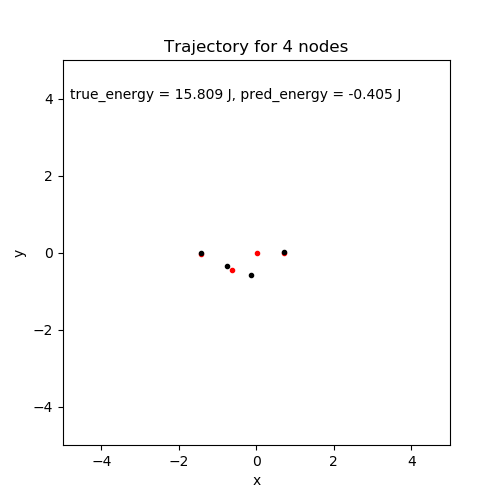

In [15]:
# Visualize trajectories
plt.close('all')
fig_animate1 = plt.figure(1, figsize=(5, 5))
ax1 = fig_animate1.add_subplot(1, 1, 1)
# Visualize trajectories for number_of_masses = 4


energy_text = ax1.text(0.02, 0.90, '', transform=ax1.transAxes)
dots = []
dots1 = []

num_nodes = true_trajectory_4_np.shape[1]
    
def init():
    for i in range(num_nodes):
        dots.append(ax1.plot([], [], linestyle='none', marker='o', markersize=3, color="r"))
        dots1.append(ax1.plot([], [], linestyle='none', marker='o', markersize=3, color="k"))
    energy_text.set_text('')
    return dots,dots1, energy_text
    
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)


def animate(z):
    for i in range(num_nodes):
        dots[i][0].set_data(true_trajectory_4_np[z,i,0],true_trajectory_4_np[z,i,1])
        dots1[i][0].set_data(predicted_trajectory_4_np[z,i,0],predicted_trajectory_4_np[z,i,1])
    energy_text.set_text("true_energy = %.3f J, pred_energy = %.3f J" % (true_energy_4_np[z],predicted_energy_4_np[z]))
    return dots,dots1,energy_text



anim = animation.FuncAnimation(fig_animate1, animate,init_func = init, interval = step_size * 5000, frames=num_time_steps, blit=False, repeat=True)
ax1.set_title("Trajectory for 4 nodes")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
plt.show()

<IPython.core.display.Javascript object>


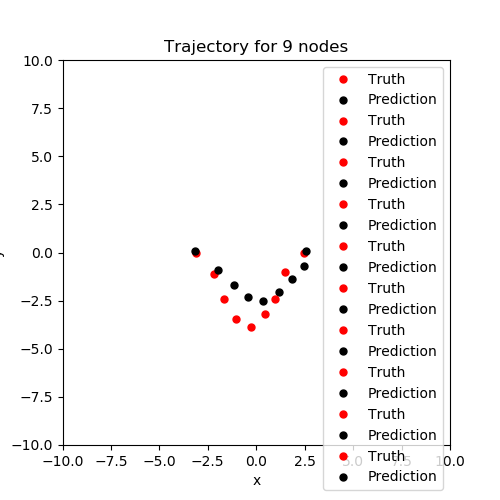

In [5]:
# Visualize trajectories
plt.close('all')
fig_animate3 = plt.figure(1, figsize=(5, 5))
ax3 = fig_animate3.add_subplot(1, 1, 1)

# Visualize trajectories for number_of_masses = 9
#energy_text = ax3.text(0.02, 0.90, '', transform=ax3.transAxes)
dots = []
dots1 = []

num_nodes = true_trajectory_9_np.shape[1]
    
def init():
    for i in range(num_nodes):
        if(i==0):
            dots.append(ax3.plot([], [], linestyle='none', marker='o', markersize=5, color="r",label="Truth"))
            dots1.append(ax3.plot([], [], linestyle='none', marker='o', markersize=5, color="k",label="Prediction"))
        else:
            dots.append(ax3.plot([], [], linestyle='none', marker='o', markersize=5, color="r"))
            dots1.append(ax3.plot([], [], linestyle='none', marker='o', markersize=5, color="k"))
    #energy_text.set_text('')
    return dots,dots1#, energy_text
    
ax3.set_xlim(-10, 10)
ax3.set_ylim(-10, 10)


def animate(z):
    for i in range(num_nodes):
        dots[i][0].set_data(true_trajectory_9_np[z,i,0],true_trajectory_9_np[z,i,1])
        dots1[i][0].set_data(predicted_trajectory_9_np[z,i,0],predicted_trajectory_9_np[z,i,1])
    #energy_text.set_text("true_energy = %.3f J, pred_energy = %.3f J" % (true_energy_9_np[z],predicted_energy_9_np[z]))
    legend = ax3.legend()
    return dots, dots1, legend#, energy_text



anim = animation.FuncAnimation(fig_animate3, animate,init_func = init, interval = 0.1 * 1000, frames=50, blit=False, repeat=True)
ax3.set_title("Trajectory for 9 nodes")
anim.save('chain.gif', writer='imagemagick', fps=20)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.show()